# 1. Importar librerías  
En esta sección importamos todas las dependencias necesarias para manipulación de datos, visualización, selección de características, reducción de dimensionalidad y modelado.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE, SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.feature_selection import SelectFromModel
from itertools import product
import time
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as ss
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_sample_weight

# 2. Carga de datos  
Leemos el fichero CSV con los datos de accidentes de tráfico y mostramos un resumen inicial de la tabla.

In [ ]:
df = pd.read_parquet('/content/part-00000-a564073c-1e21-45c0-b25b-96637310e38a-c000.snappy.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 76 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID_ACCIDENTE              97916 non-null  int64  
 1   CARRETERA                 97916 non-null  object 
 2   KM                        50944 non-null  float64
 3   ANYO                      97916 non-null  int64  
 4   MES                       97916 non-null  int64  
 5   DIA_SEMANA                97916 non-null  int64  
 6   HORA                      97916 non-null  int64  
 7   COD_PROVINCIA             97916 non-null  int64  
 8   COD_MUNICIPIO             97916 non-null  object 
 9   ISLA                      97916 non-null  object 
 10  ZONA                      97916 non-null  int64  
 11  ZONA_AGRUPADA             97916 non-null  int64  
 12  SENTIDO_1F                97916 non-null  int64  
 13  TITULARIDAD_VIA           97916 non-null  int64  
 14  TIPO_V

# 3. Definición de la variable objetivo  
Creamos `GRAVEDAD_ACCIDENTE` a partir de los conteos de víctimas mortales y graves en 24 h, y eliminamos las columnas de conteos originales.

In [ ]:
cond_grave_o_moderado = (df['TOTAL_MU24H'] > 0) | (df['TOTAL_HG24H'] > 0)

df['GRAVEDAD_ACCIDENTE'] = np.where(cond_grave_o_moderado, 'Grave', 'Leve')

# Eliminamos columnas de conteos de víctimas ya que el target está calculado
df.drop(columns=[
    'TOTAL_MU24H', 'TOTAL_HG24H', 'TOTAL_HL24H',
    'TOTAL_VICTIMAS_24H', 'TOTAL_MU30DF', 'TOTAL_HG30DF',
    'TOTAL_HL30DF', 'TOTAL_VICTIMAS_30DF', 'TOTAL_VEHICULOS',
    'TOT_PEAT_MU24H', 'TOT_BICI_MU24H', 'TOT_CICLO_MU24H',
    'TOT_MOTO_MU24H', 'TOT_TUR_MU24H', 'TOT_FURG_MU24H',
    'TOT_CAM_MENOS3500_MU24H', 'TOT_CAM_MAS3500_MU24H',
    'TOT_BUS_MU24H', 'TOT_OTRO_MU24H', 'TOT_SINESPECIF_MU24H',
    'TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF',
    'TOT_MOTO_MU30DF', 'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF',
    'TOT_CAM_MENOS3500_MU30DF', 'TOT_CAM_MAS3500_MU30DF',
    'TOT_BUS_MU30DF', 'TOT_VMP_MU30DF', 'TOT_OTRO_MU30DF',
    'TOT_SINESPECIF_MU30DF'
], inplace=True)

# Eliminamos nombres y localizaciones, nos centramos en características (muchos valores distintos también)
df.drop(columns=[
    'COD_PROVINCIA', 'COD_MUNICIPIO', 'CARRETERA', 'CARRETERA_CRUCE', 'KM'
], inplace=True)

# No aportan nada
df.drop(columns=['ID_ACCIDENTE','ANYO'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MES                      97916 non-null  int64  
 1   DIA_SEMANA               97916 non-null  int64  
 2   HORA                     97916 non-null  int64  
 3   ISLA                     97916 non-null  object 
 4   ZONA                     97916 non-null  int64  
 5   ZONA_AGRUPADA            97916 non-null  int64  
 6   SENTIDO_1F               97916 non-null  int64  
 7   TITULARIDAD_VIA          97916 non-null  int64  
 8   TIPO_VIA                 97916 non-null  int64  
 9   TIPO_ACCIDENTE           97916 non-null  int64  
 10  NUDO                     97916 non-null  int64  
 11  NUDO_INFO                97916 non-null  object 
 12  PRIORI_NORMA             97916 non-null  int64  
 13  PRIORI_AGENTE            97916 non-null  int64  
 14  PRIORI_SEMAFORO       

In [ ]:

# Imprimir la distribución en forma de tabla (conteo de cada categoría)
print("Distribución de la variable GRAVEDAD_ACCIDENTE:")
print(df['GRAVEDAD_ACCIDENTE'].value_counts())

# Opcional: Imprimir la distribución en porcentaje
print("\nDistribución porcentual de GRAVEDAD_ACCIDENTE:")
print(df['GRAVEDAD_ACCIDENTE'].value_counts(normalize=True) * 100)

Distribución de la variable GRAVEDAD_ACCIDENTE:
GRAVEDAD_ACCIDENTE
Leve     88895
Grave     9021
Name: count, dtype: int64

Distribución porcentual de GRAVEDAD_ACCIDENTE:
GRAVEDAD_ACCIDENTE
Leve     90.787001
Grave     9.212999
Name: proportion, dtype: float64


In [ ]:
df.head()

,MES,DIA_SEMANA,HORA,ISLA,ZONA,ZONA_AGRUPADA,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,TIPO_ACCIDENTE,...,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,TRAFICO_LIGERO,TRAFICO_PESADO,TRAFICO_TOTAL,GRAVEDAD_ACCIDENTE
0,2,5,14,14,3,2,4,4,9,2,...,1,999,0,2,998,998,NaN,NaN,NaN,Grave
1,9,6,12,14,3,2,4,4,9,9,...,2,999,0,1,998,998,NaN,NaN,NaN,Leve
2,5,1,10,1,3,2,4,4,9,4,...,1,999,0,1,998,998,NaN,NaN,NaN,Leve
3,2,4,18,14,1,1,4,4,2,4,...,1,999,0,18,998,4,NaN,NaN,NaN,Leve
4,12,1,16,14,3,2,4,4,9,3,...,1,999,0,1,998,998,NaN,NaN,NaN,Leve


# 4. División Train / Validation / Test  
Definimos una función `split_data` para crear subconjuntos estratificados y la aplicamos para obtener `train`, `val` y `test`.

In [ ]:
def split_data(df, target, test_size=0.3, val_size=0.5, random_state=42):
    train, temp = train_test_split(df, test_size=test_size,
                                   stratify=df[target], random_state=random_state)
    val, test  = train_test_split(temp, test_size=val_size,
                                   stratify=temp[target], random_state=random_state)
    return train, val, test


train,val,test = split_data(df, 'GRAVEDAD_ACCIDENTE')
print(f'Tamaño del conjunto de entrenamiento: {train.shape}')
print(f'Tamaño del conjunto de validación: {val.shape}')
print(f'Tamaño del conjunto de prueba: {test.shape}')

Tamaño del conjunto de entrenamiento: (68541, 38)
Tamaño del conjunto de validación: (14687, 38)
Tamaño del conjunto de prueba: (14688, 38)


In [ ]:
X_train = train.drop(columns=['GRAVEDAD_ACCIDENTE'])
y_train = train['GRAVEDAD_ACCIDENTE']
X_val = val.drop(columns=['GRAVEDAD_ACCIDENTE'])
y_val = val['GRAVEDAD_ACCIDENTE']
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(68541, 37)
(68541,)
(14687, 37)
(14687,)


In [ ]:
EDA_train_raw = X_train.copy()
EDA_train_raw['GRAVEDAD_ACCIDENTE'] = y_train
EDA_train_raw.head()

,MES,DIA_SEMANA,HORA,ISLA,ZONA,ZONA_AGRUPADA,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,TIPO_ACCIDENTE,...,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,TRAFICO_LIGERO,TRAFICO_PESADO,TRAFICO_TOTAL,GRAVEDAD_ACCIDENTE
3483,1,5,9,14,3,2,4,4,9,2,...,1,999,0,18,998,998,NaN,NaN,NaN,Leve
17090,1,3,18,14,2,2,3,2,6,12,...,1,999,0,1,998,1,NaN,NaN,NaN,Leve
76018,12,5,13,14,1,1,2,1,3,2,...,3,999,0,1,998,1,NaN,NaN,NaN,Leve
74653,7,6,12,14,3,2,4,4,9,2,...,1,999,0,1,998,998,NaN,NaN,NaN,Leve
71159,4,5,21,14,3,2,4,4,9,10,...,1,999,0,1,998,998,NaN,NaN,NaN,Grave


# 5. Exploración y limpieza de nulos  
Calculamos el porcentaje de valores faltantes en el conjunto de entrenamiento y los rellenamos:
- Las numéricas con 0.  
- Las categóricas con `"missing"`.  
- Conversiones y reemplazo de códigos 998/999 por `missing`.

In [ ]:
EDA_train_raw.isna().sum()

porcentaje_nulos = (EDA_train_raw.isna().sum() / len(EDA_train_raw)) * 100
print(porcentaje_nulos)

MES                         0.000000
DIA_SEMANA                  0.000000
HORA                        0.000000
ISLA                        0.000000
ZONA                        0.000000
ZONA_AGRUPADA               0.000000
SENTIDO_1F                  0.000000
TITULARIDAD_VIA             0.000000
TIPO_VIA                    0.000000
TIPO_ACCIDENTE              0.000000
NUDO                        0.000000
NUDO_INFO                   0.000000
PRIORI_NORMA                0.000000
PRIORI_AGENTE               0.000000
PRIORI_SEMAFORO             0.000000
PRIORI_VERT_STOP            0.000000
PRIORI_VERT_CEDA            0.000000
PRIORI_HORIZ_STOP           0.000000
PRIORI_HORIZ_CEDA           0.000000
PRIORI_MARCAS               0.000000
PRIORI_PEA_NO_ELEV          0.000000
PRIORI_PEA_ELEV             0.000000
PRIORI_MARCA_CICLOS         0.000000
PRIORI_CIRCUNSTANCIAL       0.000000
PRIORI_OTRA                 0.000000
CONDICION_NIVEL_CIRCULA     0.000000
CONDICION_FIRME             0.000000
C

In [ ]:
EDA_train_clean = EDA_train_raw.copy()
EDA_train_clean['GRAVEDAD_ACCIDENTE'] = y_train

numeric_cols = EDA_train_clean.select_dtypes(include=np.number).columns
EDA_train_clean[numeric_cols] = EDA_train_clean[numeric_cols].fillna(0)

# Verificamos que no haya más nulos
print(EDA_train_clean.isnull().sum())

MES                        0
DIA_SEMANA                 0
HORA                       0
ISLA                       0
ZONA                       0
ZONA_AGRUPADA              0
SENTIDO_1F                 0
TITULARIDAD_VIA            0
TIPO_VIA                   0
TIPO_ACCIDENTE             0
NUDO                       0
NUDO_INFO                  0
PRIORI_NORMA               0
PRIORI_AGENTE              0
PRIORI_SEMAFORO            0
PRIORI_VERT_STOP           0
PRIORI_VERT_CEDA           0
PRIORI_HORIZ_STOP          0
PRIORI_HORIZ_CEDA          0
PRIORI_MARCAS              0
PRIORI_PEA_NO_ELEV         0
PRIORI_PEA_ELEV            0
PRIORI_MARCA_CICLOS        0
PRIORI_CIRCUNSTANCIAL      0
PRIORI_OTRA                0
CONDICION_NIVEL_CIRCULA    0
CONDICION_FIRME            0
CONDICION_ILUMINACION      0
CONDICION_METEO            0
CONDICION_NIEBLA           0
CONDICION_VIENTO           0
VISIB_RESTRINGIDA_POR      0
ACERA                      0
TRAZADO_PLANTA             0
TRAFICO_LIGERO

In [ ]:
EDA_train_cat = EDA_train_clean.copy()
EDA_train_cat.describe()

,MES,DIA_SEMANA,HORA,ZONA,ZONA_AGRUPADA,SENTIDO_1F,TITULARIDAD_VIA,TIPO_VIA,TIPO_ACCIDENTE,NUDO,...,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,TRAFICO_LIGERO,TRAFICO_PESADO,TRAFICO_TOTAL
count,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,...,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000,68541.000000
mean,6.658453,3.884274,13.728848,2.301440,1.658234,3.325790,3.409696,7.683299,7.212690,1.616901,...,104.825185,1.428269,1.926803,1.317416,6.173006,899.598416,641.296290,0.044409,3.444019,1.089952
std,3.366861,1.933442,5.352241,0.946304,0.474305,1.130945,1.071750,2.374164,5.718597,0.486146,...,301.820366,1.327421,1.575314,0.945636,7.587415,297.022873,477.508686,1.425175,44.797282,15.644174
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,10.000000,1.000000,1.000000,2.000000,3.000000,6.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,998.000000,3.000000,0.000000,0.000000,0.000000
50%,7.000000,4.000000,14.000000,3.000000,2.000000,4.000000,4.000000,9.000000,5.000000,2.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,998.000000,998.000000,0.000000,0.000000,0.000000
75%,10.000000,5.000000,18.000000,3.000000,2.000000,4.000000,4.000000,9.000000,10.000000,2.000000,...,6.000000,1.000000,3.000000,1.000000,18.000000,998.000000,998.000000,0.000000,0.000000,0.000000
max,12.000000,7.000000,23.000000,4.000000,2.000000,4.000000,5.000000,14.000000,20.000000,2.000000,...,999.000000,9.000000,6.000000,7.000000,18.000000,999.000000,998.000000,68.846000,997.000000,984.000000


In [ ]:
cols = ['TITULARIDAD_VIA', 'NUDO_INFO', 'PRIORI_NORMA', 'PRIORI_AGENTE', 'PRIORI_SEMAFORO', 'PRIORI_VERT_STOP',
        'PRIORI_VERT_CEDA', 'PRIORI_HORIZ_STOP', 'PRIORI_HORIZ_CEDA', 'PRIORI_MARCAS', 'PRIORI_PEA_NO_ELEV',
        'PRIORI_PEA_ELEV', 'PRIORI_MARCA_CICLOS', 'PRIORI_CIRCUNSTANCIAL', 'PRIORI_OTRA','CONDICION_NIVEL_CIRCULA','CONDICION_FIRME',
        'CONDICION_ILUMINACION','CONDICION_METEO','VISIB_RESTRINGIDA_POR','ACERA','TRAZADO_PLANTA']
for c in cols:
    EDA_train_cat[c] = EDA_train_cat[c].replace({998: np.nan, 999: np.nan})

# Verificamos que no haya más nulos
porcentaje_nulos = (EDA_train_cat.isna().sum() / len(EDA_train_cat)) * 100
print(porcentaje_nulos)

MES                         0.000000
DIA_SEMANA                  0.000000
HORA                        0.000000
ISLA                        0.000000
ZONA                        0.000000
ZONA_AGRUPADA               0.000000
SENTIDO_1F                  0.000000
TITULARIDAD_VIA             0.000000
TIPO_VIA                    0.000000
TIPO_ACCIDENTE              0.000000
NUDO                        0.000000
NUDO_INFO                   0.000000
PRIORI_NORMA               61.693001
PRIORI_AGENTE              61.693001
PRIORI_SEMAFORO            61.693001
PRIORI_VERT_STOP           61.693001
PRIORI_VERT_CEDA           61.693001
PRIORI_HORIZ_STOP          61.693001
PRIORI_HORIZ_CEDA          61.693001
PRIORI_MARCAS              61.693001
PRIORI_PEA_NO_ELEV         61.693001
PRIORI_PEA_ELEV            61.693001
PRIORI_MARCA_CICLOS        61.693001
PRIORI_CIRCUNSTANCIAL      61.693001
PRIORI_OTRA                61.693001
CONDICION_NIVEL_CIRCULA    10.227455
CONDICION_FIRME             0.000000
C

In [ ]:
cat_cols = EDA_train_cat.columns
for col in cat_cols:
    EDA_train_cat[col] = EDA_train_cat[col].astype('str').astype('category') #para ohe
    EDA_train_cat[col] = EDA_train_cat[col].astype(str).fillna('missing')


# Verificamos que no haya más nulos
porcentaje_nulos = (EDA_train_cat.isna().sum() / len(EDA_train_cat)) * 100
print(porcentaje_nulos)

MES                        0.0
DIA_SEMANA                 0.0
HORA                       0.0
ISLA                       0.0
ZONA                       0.0
ZONA_AGRUPADA              0.0
SENTIDO_1F                 0.0
TITULARIDAD_VIA            0.0
TIPO_VIA                   0.0
TIPO_ACCIDENTE             0.0
NUDO                       0.0
NUDO_INFO                  0.0
PRIORI_NORMA               0.0
PRIORI_AGENTE              0.0
PRIORI_SEMAFORO            0.0
PRIORI_VERT_STOP           0.0
PRIORI_VERT_CEDA           0.0
PRIORI_HORIZ_STOP          0.0
PRIORI_HORIZ_CEDA          0.0
PRIORI_MARCAS              0.0
PRIORI_PEA_NO_ELEV         0.0
PRIORI_PEA_ELEV            0.0
PRIORI_MARCA_CICLOS        0.0
PRIORI_CIRCUNSTANCIAL      0.0
PRIORI_OTRA                0.0
CONDICION_NIVEL_CIRCULA    0.0
CONDICION_FIRME            0.0
CONDICION_ILUMINACION      0.0
CONDICION_METEO            0.0
CONDICION_NIEBLA           0.0
CONDICION_VIENTO           0.0
VISIB_RESTRINGIDA_POR      0.0
ACERA   

Algunos modelos (o transformaciones previas) podrían intentar imputar o escalar “998” o “999” como si fuera un valor extremo numérico, o codificarlo directamente en múltiples dummies. Convertirlo primero a NaN y luego a “missing” asegura que sólo genere una variable dummy (“falta dato”).

# 6. Selección de características univariante  
Realiza la selección univariante de variables categóricas mediante χ², ANOVA F-test y Mutual Information,
agrega los resultados por variable original y visualiza los top 30 según cada métrica.

=== ANOVA F-test (top 30) ===
                    feature     F_value        p_value
26               SENTIDO_1F  642.239520   6.218871e-71
36            ZONA_AGRUPADA  487.005939  1.516238e-107
29          TITULARIDAD_VIA  443.248181   4.623439e-38
33           TRAZADO_PLANTA  377.859625   3.879804e-43
5   CONDICION_NIVEL_CIRCULA  278.035474   2.077149e-01
35                     ZONA  180.913771   2.451690e-01
0                     ACERA  171.984997   9.586601e-03
4          CONDICION_NIEBLA  123.385221   2.115637e-01
28                 TIPO_VIA  102.622977   2.191628e-01
11                     NUDO   92.749948   6.126788e-22
27           TIPO_ACCIDENTE   85.521060   6.810960e-02
34    VISIB_RESTRINGIDA_POR   67.778333   1.656758e-01
2     CONDICION_ILUMINACION   48.167451   2.041157e-01
7                DIA_SEMANA   28.119699   6.352282e-03
24         PRIORI_VERT_CEDA   23.061543   1.598154e-06
22       PRIORI_PEA_NO_ELEV   22.633195   2.127634e-06
25         PRIORI_VERT_STOP   20.53

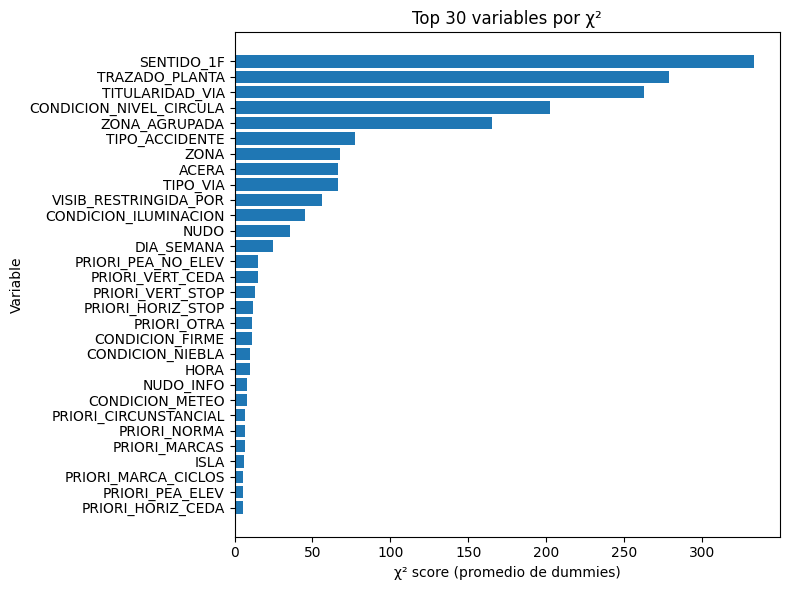

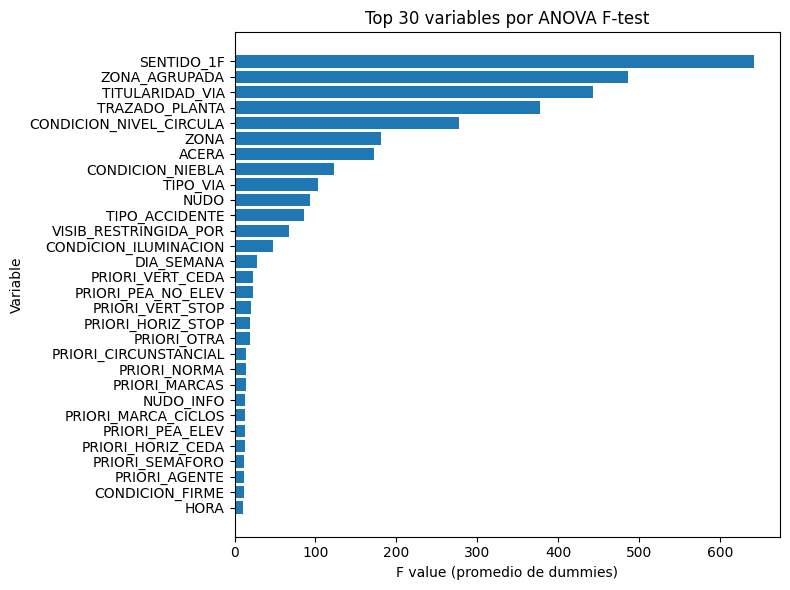

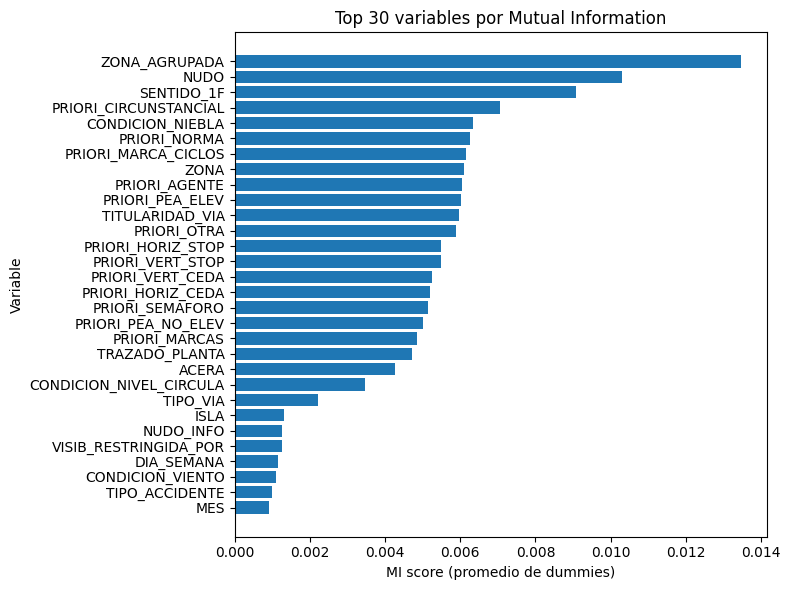

In [ ]:
# 1) Filtrar columnas categóricas (excepto el target)
cols_for_x_cat = [c for c in cat_cols if c != 'GRAVEDAD_ACCIDENTE']

# 2) Extraer el subset categórico y crear dummies
X_cat     = EDA_train_cat[cols_for_x_cat]
X_dummies = pd.get_dummies(X_cat, drop_first=True)

# 3) Codificar el target
y = EDA_train_cat['GRAVEDAD_ACCIDENTE'].astype('category').cat.codes

# 4) Calcular χ², ANOVA F-test y Mutual Information
chi2_scores, chi2_p    = chi2(X_dummies, y)
f_scores,    f_pvalues = f_classif(X_dummies, y)
mi_scores               = mutual_info_classif(X_dummies, y, random_state=42)

# 5) Agregar resultados de ANOVA F-test por variable original
f_df = pd.DataFrame({
    'feature': X_dummies.columns,
    'F_value': f_scores,
    'p_value': f_pvalues
})
f_df['orig_feature'] = f_df['feature'].str.rsplit('_', n=1).str[0]
f_agg = (
    f_df
    .groupby('orig_feature')
    .agg({'F_value':'mean', 'p_value':'mean'})
    .reset_index()
    .sort_values('F_value', ascending=False)
)
top30_f = f_agg.head(30)
print("=== ANOVA F-test (top 30) ===")
print(top30_f[['orig_feature','F_value','p_value']].rename(columns={'orig_feature':'feature'}))

def agg_series(scores):
    """
    Agrega una serie de puntuaciones de dummies por su variable original.

    Parámetros
    ----------
    scores : array-like
        Puntuaciones de una métrica (χ² o MI) para cada dummy.

    Devuelve
    -------
    pandas.Series
        Media de las puntuaciones agrupadas por variable original,
        ordenada de mayor a menor.
    """
    ser = pd.Series(scores, index=X_dummies.columns)
    orig = ser.index.to_series().str.rsplit('_', n=1).str[0]
    return ser.groupby(orig).mean().sort_values(ascending=False)

# 6) Preparar agregados para χ² y MI
chi2_agg = agg_series(chi2_scores)
mi_agg   = agg_series(mi_scores)

# 7) Visualización de top N variables según cada métrica
top_n = 30

# χ²
plt.figure(figsize=(8, 6))
plt.barh(chi2_agg.head(top_n)[::-1].index,
         chi2_agg.head(top_n)[::-1].values)
plt.title(f'Top {top_n} variables por χ²')
plt.xlabel('χ² score (promedio de dummies)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# ANOVA F-test
plt.figure(figsize=(8, 6))
plt.barh(top30_f['orig_feature'].head(top_n)[::-1],
         top30_f['F_value'].head(top_n)[::-1])
plt.title(f'Top {top_n} variables por ANOVA F-test')
plt.xlabel('F value (promedio de dummies)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Mutual Information
plt.figure(figsize=(8, 6))
plt.barh(mi_agg.head(top_n)[::-1].index,
         mi_agg.head(top_n)[::-1].values)
plt.title(f'Top {top_n} variables por Mutual Information')
plt.xlabel('MI score (promedio de dummies)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


   Calcula la V de Cramér (Cramér's V), una medida de asociación entre dos variables categóricas. Esta métrica cuantifica la fuerza de asociación entre dos variables categóricas en un rango de 0 a 1, donde 0 indica independencia total y 1 indica asociación perfecta. Se basa en la prueba de chi-cuadrado.

In [ ]:
def cramers_v(x, y):
    """
    Parámetros
    ----------
    x : array-like o pandas.Series
        Primera variable categórica (por ejemplo, una característica del conjunto de datos).

    y : array-like o pandas.Series
        Segunda variable categórica (por ejemplo, la variable objetivo o etiqueta).

    Retorna
    -------
    float
        Valor de V de Cramér, entre 0 y 1.
    """
    conf = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(conf)[0]
    n = conf.sum().sum()
    k = min(conf.shape) - 1
    return np.sqrt((chi2 / n) / k)


results = []
for feat in f_agg['orig_feature']:
    v = cramers_v(EDA_train_cat[feat], EDA_train_cat['GRAVEDAD_ACCIDENTE'])
    results.append((feat, v))

cramers_df = pd.DataFrame(results, columns=['feature','cramers_v'])
print(cramers_df.sort_values('cramers_v', ascending=False).head(20))


                    feature  cramers_v
10           TIPO_ACCIDENTE   0.168775
34            TRAFICO_TOTAL   0.154692
4   CONDICION_NIVEL_CIRCULA   0.153954
35           TRAFICO_PESADO   0.148144
3            TRAZADO_PLANTA   0.147050
0                SENTIDO_1F   0.139561
2           TITULARIDAD_VIA   0.126093
11    VISIB_RESTRINGIDA_POR   0.122604
8                  TIPO_VIA   0.112470
5                      ZONA   0.087265
6                     ACERA   0.087205
1             ZONA_AGRUPADA   0.083943
7          CONDICION_NIEBLA   0.060484
12    CONDICION_ILUMINACION   0.059824
29                     HORA   0.058630
13               DIA_SEMANA   0.047017
22                NUDO_INFO   0.046319
33           TRAFICO_LIGERO   0.042252
9                      NUDO   0.036710
28          CONDICION_FIRME   0.036449



*   0.00–0.10: asociación muy débil
*   0.10–0.30: asociación débil a moderada
*   mayor que 0.30 asociación fuerte


Por lo que podemos observar que las relaciones son muy débiles, lo que dificultará la predicción

# 7. Reducción de dimensionalidad con TruncatedSVD  
A continuación, combinamos las métricas de χ², ANOVA y Mutual Information para rankear las variables, seleccionamos las 20 mejores y reducimos la dimensionalidad con TruncatedSVD para retener el 95 % de la varianza.


Seleccionadas: 25 variables
Columnas tras preprocesado (matriz sparse): 92
Componentes para 95% varianza (SVD): 30


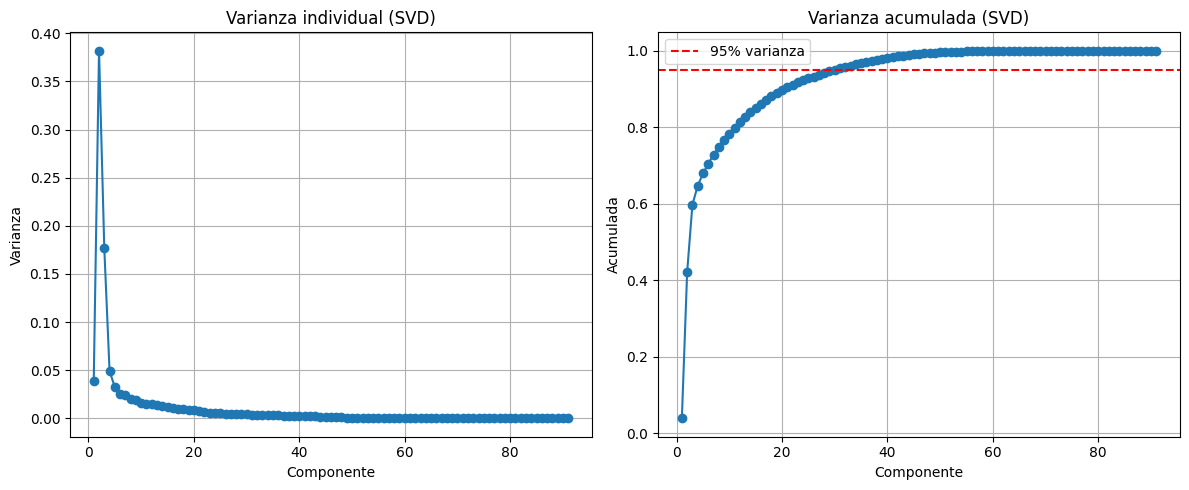


Componentes (aproximados):
       cat__SENTIDO_1F_1  cat__SENTIDO_1F_2  cat__SENTIDO_1F_3  \
SVD1            0.035750           0.032525           0.005505   
SVD2           -0.041350          -0.040439          -0.003518   
SVD3            0.155454           0.138910           0.023378   
SVD4           -0.069326          -0.060706          -0.004502   
SVD5           -0.063512          -0.051625          -0.018164   
SVD6           -0.009180          -0.024151           0.016007   
SVD7           -0.066373          -0.072653           0.022497   
SVD8            0.096359           0.070374          -0.019435   
SVD9           -0.100340          -0.004834          -0.039056   
SVD10          -0.042381          -0.033227          -0.006032   
SVD11           0.187700          -0.256153          -0.000014   
SVD12           0.664628          -0.587405          -0.004987   
SVD13          -0.159480           0.306439           0.015887   
SVD14           0.017298          -0.010118     

In [ ]:
# 1) Selección de las N variables mejor valoradas por cada métrica univariante
N = 25
top_chi2 = chi2_agg.head(N).index.tolist()
top_f    = f_agg.head(N).index.tolist()
top_mi   = mi_agg.head(N).index.tolist()

def make_rank_df(series, name):
    """
    Genera un DataFrame de ranking para una serie de puntuaciones.

    Parámetros
    ----------
    series : pandas.Series
        Serie cuyos índices son nombres de variables y sus valores las puntuaciones
        según una métrica (χ², F-test, MI).
    name : str
        Prefijo para nombrar la columna de índice en el DataFrame resultante.

    Devuelve
    -------
    pandas.DataFrame
        DataFrame con índice = nombres de variables y dos columnas:
        - <name>       : lista ordenada de los primeros N nombres de variables.
        - <name>_rank  : rango (1..N) correspondiente a cada variable.
    """
    df = pd.DataFrame({
        name: series.head(N).index,
        f"{name}_rank": range(1, N+1)
    }).set_index(name)
    return df

# 2) Construcción de los DataFrames de ranking
df_chi2 = make_rank_df(chi2_agg, 'chi2')
df_f    = make_rank_df(f_agg,    'f')
df_mi   = make_rank_df(mi_agg,   'mi')

# 3) Concatenación de rankings y relleno de valores faltantes con N+1
rank_df = pd.concat([df_chi2, df_f, df_mi], axis=1).fillna(N+1)

# 4) Cálculo del score agregado y selección de las top N
rank_df['agg_score'] = rank_df['chi2_rank'] + rank_df['f_rank'] + rank_df['mi_rank']
selected_features = rank_df.sort_values('agg_score').head(N).index.tolist()
print(f"Seleccionadas: {len(selected_features)} variables")

# 5) Filtrado para quedarnos sólo con las variables categóricas seleccionadas
cat_cols_sel = [c for c in selected_features if c in EDA_train_cat.columns]

# 6) One-Hot Encoding de las variables categóricas seleccionadas
preprocessor_temp = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), cat_cols_sel)
])
X_encoded = preprocessor_temp.fit_transform(EDA_train_cat)
print("Columnas tras preprocesado (matriz sparse):", X_encoded.shape[1])

# 7) Aplicación de TruncatedSVD
svd = TruncatedSVD(n_components=min(100, X_encoded.shape[1] - 1), random_state=42)
X_svd = svd.fit_transform(X_encoded)

# 8) Cálculo de varianza explicada y número de componentes para 95% de varianza
explained_variance = svd.explained_variance_ratio_
cum_variance       = np.cumsum(explained_variance)
n95                = np.argmax(cum_variance >= 0.95) + 1
print(f"Componentes para 95% varianza (SVD): {n95}")

# 9) Visualización de la varianza individual y acumulada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-')
plt.title('Varianza individual (SVD)')
plt.xlabel('Componente')
plt.ylabel('Varianza')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cum_variance) + 1), cum_variance, 'o-')
plt.axhline(0.95, color='r', ls='--', label='95% varianza')
plt.title('Varianza acumulada (SVD)')
plt.xlabel('Componente')
plt.ylabel('Acumulada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 10) Extracción de las componentes SVD para interpretación
svd95   = TruncatedSVD(n_components=n95, random_state=42)
X_svd95 = svd95.fit_transform(X_encoded)

loadings = pd.DataFrame(
    svd95.components_,
    columns=preprocessor_temp.get_feature_names_out(),
    index=[f'SVD{i + 1}' for i in range(n95)]
)

print("\nComponentes (aproximados):")
print(loadings)


# 8. Definición del Pipeline final  
Montamos un pipeline que incluye:
- Imputación y escalado de numéricas.  
- Imputación y one-hot de categóricas.  
- PCA para reducción.  
- Clasificador (RF, SVM, etc.).  

In [ ]:
target = 'GRAVEDAD_ACCIDENTE'

X_train = train.drop(columns=[target])
y_train = train[target]

X_val = val.drop(columns=[target])
y_val = val[target]

X_test = test.drop(columns=[target])
y_test = test[target]

# Codificar las etiquetas con LabelEncoder
le = LabelEncoder()
le.fit(y_train)

y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [ ]:
# Tomar una muestra estratificada del 10% del conjunto de entrenamiento para pruebas rápidas
train_sample, _ = train_test_split(train, test_size=0.9, stratify=train[target], random_state=42)

X_train_sample = train_sample.drop(columns=[target])
y_train_sample = train_sample[target]
y_train_sample_enc = le.transform(y_train_sample)

In [ ]:
class ReplaceValuesTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado para reemplazar valores específicos en columnas seleccionadas de un DataFrame.

    Este transformador permite reemplazar ciertos valores (por ejemplo, códigos como 998 o 999) en columnas
    categóricas o mixtas por otro valor (por defecto `np.nan`), lo cual es útil para tratar datos faltantes
    codificados manualmente. Forma parte de un pipeline de preprocesamiento compatible con scikit-learn.

    Parámetros
    ----------
    values_to_replace : list
        Lista de valores que se desean reemplazar. Pueden ser enteros, cadenas, etc.

    cols_to_process : list of str
        Lista de nombres de columnas en las que se debe realizar el reemplazo.

    replace_with : valor escalar, predeterminado np.nan
        Valor con el que se reemplazarán las coincidencias encontradas en las columnas indicadas.

    Ejemplo
    -------
    >>> transformer = ReplaceValuesTransformer(values_to_replace=[998, 999], cols_to_process=['col1', 'col2'])
    >>> X_transformed = transformer.fit_transform(X)

    Notas
    -----
    - Las columnas que no son de tipo numérico ni objeto se convierten a tipo string antes del reemplazo.
    - El reemplazo se realiza tras convertir la columna a tipo string, por lo que todas las comparaciones se hacen
      contra representaciones en texto.
    - Este transformador no altera las columnas no especificadas.
    - Se ignoran silenciosamente las columnas indicadas que no estén presentes en el DataFrame.
    """

    def __init__(self, values_to_replace, cols_to_process, replace_with=np.nan):
        self.values_to_replace = values_to_replace
        self.cols_to_process = cols_to_process
        self.replace_with = replace_with

    def fit(self, X, y=None):
        """
        No fitting is needed for this transformer.
        Returns self.
        """
        return self

    def transform(self, X):
        """
        Aplica el reemplazo de valores en las columnas especificadas del DataFrame.

        Parámetros
        ----------
        X : pandas.DataFrame
            Conjunto de datos de entrada. Debe contener las columnas indicadas en `cols_to_process`.

        Retorna
        -------
        X_transformed : pandas.DataFrame
            Copia del DataFrame de entrada con los valores especificados reemplazados en las columnas seleccionadas.
        """
        X_transformed = X.copy()

        for col in self.cols_to_process:
            if col in X_transformed.columns:
                # Asegurarse de que la columna sea tipo compatible
                if not pd.api.types.is_numeric_dtype(X_transformed[col]) and not pd.api.types.is_object_dtype(X_transformed[col]):
                    X_transformed[col] = X_transformed[col].astype(str)

                # Reemplazo iterativo por cada valor
                for value in self.values_to_replace:
                    X_transformed[col] = X_transformed[col].astype(str).replace(value, self.replace_with)

        return X_transformed

In [ ]:
cols_to_keep_numeric = []

# Obtener todas las columnas excepto las que queremos mantener como numéricas
cols_to_convert_to_category = [col for col in X_train.columns if col not in cols_to_keep_numeric]

# Convertir las columnas seleccionadas a tipo category
for col in cols_to_convert_to_category:
    X_train[col] = X_train[col].astype(str).astype('category')


# Detectar columnas numéricas y categóricas desde el conjunto de entrenamiento
selected_numeric = [col for col in selected_features if col in X_train.select_dtypes(include=np.number).columns]
selected_categorical = [col for col in selected_features if col in X_train.select_dtypes(include=['category']).columns]


# Preprocesamiento numérico
numeric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Preprocesamiento categórico
categorical_pipeline = Pipeline(steps=[
    ('replace_codes', ReplaceValuesTransformer(values_to_replace=[998, 999], cols_to_process=selected_categorical, replace_with=np.nan)),
    ('to_string', FunctionTransformer(lambda x: x.astype(str), validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer con ambos tipos
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_imputer, selected_numeric),
    ('cat', categorical_pipeline, selected_categorical)
])


neg, pos = np.bincount(y_train_sample_enc)
scale_pos_weight = neg / pos


# Modelos a evaluar
classifiers = {
    'XGBoost': XGBClassifier(objective='binary:logistic', eval_metric='logloss',scale_pos_weight=scale_pos_weight, alpha=0.75, gamma=2.0, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SGD': SGDClassifier(random_state=42,class_weight='balanced'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42,class_weight='balanced'),
}

# Parámetros para búsqueda
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100,150, 200],
        'classifier__max_depth': [100,150,200]
    },
    'SGD': {
        'classifier__loss': ['log_loss', 'hinge'],
        'classifier__alpha': np.logspace(-5, -3, 5),
        'classifier__penalty': ['l2', 'l1']
    },
    'LogisticRegression': {
        'classifier__C': np.logspace(-4, 1, 5),
        'classifier__penalty': ['l2']
    },
    'SVM': {
        'classifier__C': np.logspace(0, 3, 5),
        'classifier__kernel': ['rbf']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 250,325],
        'classifier__max_depth': [35, 50, 65]
    }
}

In [118]:
# 1) ¿Cuántas features originales seleccionaste?
print("Features originales seleccionadas:", len(selected_features))

# 2) Tras el preprocessor (numéricas + one‐hot), ¿cuántas columnas tienes?
X_train_prep = preprocessor.fit_transform(X_train)
print("Columnas tras preprocesado (matriz sparse):", X_train_prep.shape[1])

# 3) Ahora el SVD provisional
from sklearn.decomposition import TruncatedSVD
svd_temp = TruncatedSVD(n_components=X_train_prep.shape[1], random_state=42)
svd_temp.fit(X_train_prep)
cum_var = svd_temp.explained_variance_ratio_.cumsum()
k99    = np.searchsorted(cum_var, 0.99) + 1
print("Componentes (SVD) para 99 % varianza:", k99)

# Configura CV para RandomizedSearch:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=25) #clases desbalanceadas

best_models = {}
best_params = {}
scores = {}
training_times = {}


for name, model in classifiers.items():
    print(f"\n🔍 Evaluando modelo: {name}")

    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor),
        ('resample', SMOTEENN(random_state=42)),
        ('svd', TruncatedSVD(n_components=k99)),
        ('classifier', model)
    ])

    pg = param_grids[name]
    n_combinations = np.prod([len(v) for v in pg.values()])
    n_iter = min(6, int(n_combinations))

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=pg,
        n_iter=n_iter,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Iniciar el contador de tiempo
    start_time = time.time()

    # Ajustar el modelo. Pasar sample_weight solo para XGBoost.
    fit_params = {}

    random_search.fit(X_train_sample, y_train_sample_enc)

    # Detener el contador de tiempo y almacenar el resultado
    end_time = time.time()
    training_times[name] = end_time - start_time
    for name, total_seconds in training_times.items():
        minutes = int(total_seconds // 60)
        seconds = int(total_seconds % 60)
    print(f"Tiempo de entrenamiento para {name}: {minutes} minutos y {seconds} segundos")

    # Guardamos mejor
    best_model = random_search.best_estimator_
    best_models[name] = best_model
    best_params[name] = random_search.best_params_

    # Evaluación final en el test independiente:
    y_pred_test = best_model.predict(X_test)

    f1 = f1_score(y_test_enc , y_pred_test)  #cambiar a y_test
    print(f"✅ Mejor params: {random_search.best_params_}")
    print(f"✅ F1 en test: {f1:.4f}")
    scores[name] = f1

Features originales seleccionadas: 25
Columnas tras preprocesado (matriz sparse): 93
Componentes (SVD) para 99 % varianza: 46

🔍 Evaluando modelo: XGBoost
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Tiempo de entrenamiento para XGBoost: 1 minutos y 50 segundos
✅ Mejor params: {'classifier__n_estimators': 250, 'classifier__max_depth': 50}
✅ F1 en test: 0.6106

🔍 Evaluando modelo: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Tiempo de entrenamiento para RandomForest: 3 minutos y 9 segundos
✅ Mejor params: {'classifier__n_estimators': 200, 'classifier__max_depth': 100}
✅ F1 en test: 0.7022

🔍 Evaluando modelo: SGD
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Tiempo de entrenamiento para SGD: 1 minutos y 25 segundos
✅ Mejor params: {'classifier__penalty': 'l1', 'classifier__loss': 'log_loss', 'classifier__alpha': np.float64(0.001)}
✅ F1 en test: 0.7458

🔍 Evaluando modelo: LogisticRegression
Fitting 3 folds for each of 5 candidates


*   Compatibilidad con datos dispersos (sparse): después de aplicar OneHotEncoder a variables categóricas, el resultado es una matriz con muchísimos ceros y muy pocos unos; es decir, una matriz sparse.


*   PCA tradicional con svd_solver='full' o 'randomized' no soporta este formato sparse y exige convertir la matriz a densa (lo cual dispara el uso de memoria).


*   TruncatedSVD es la versión de PCA diseñada para trabajar directamente con matrices sparse sin necesidad de densificarlas, ofreciendo reducción de dimensionalidad equivalente (en términos de componentes principales) pero de forma mucho más eficiente en memoria.






# 10. Evaluación final en Test  
Seleccionamos el mejor modelo según la media de F1 y reportamos métricas (accuracy, F1, recall, precision) en el conjunto de prueba.

In [121]:
mejor_modelo = max(scores, key=lambda k: np.mean(scores[k]))
print(f"\n🏆 Mejor modelo: {mejor_modelo}")
print(f"🛠️  Mejores hiperparámetros: {best_params[mejor_modelo]}")

# 6️⃣ Predicción y reporte en test
final_model = best_models[mejor_modelo]
y_pred_test = final_model.predict(X_test)

# Decodificar a etiquetas originales
y_pred_labels = le.inverse_transform(y_pred_test)
y_test_labels = le.inverse_transform(y_test_enc)

print("\n📊 Reporte en conjunto de prueba:")
print(classification_report(y_test_labels, y_pred_labels))


🏆 Mejor modelo: LogisticRegression
🛠️  Mejores hiperparámetros: {'classifier__penalty': 'l2', 'classifier__C': np.float64(0.0017782794100389228)}

📊 Reporte en conjunto de prueba:
              precision    recall  f1-score   support

       Grave       0.16      0.61      0.25      1353
        Leve       0.94      0.67      0.78     13335

    accuracy                           0.66     14688
   macro avg       0.55      0.64      0.52     14688
weighted avg       0.87      0.66      0.73     14688

